# Federated Insurance

Open

- [ ] RSquared for FL, but it is only available in tf-nightly and the installation broke the env
- [ ] cache result
- [x] centralized: does CSV Logger work with TFF? Or instead save the hist manually as csv
- [x] logging/caching federated
- [ ] document input and outputs in FLutils
- [ ] move to and test colab

## Prerequisites
---

In [1]:
# Setup colab if needed

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

print("COLAB? {}".format(IN_COLAB))

if IN_COLAB:
    import os
    
    # rm repo from gdrive
    if os.path.exists("fl-official-statistics-addon"):
      %rm -r fl-official-statistics-addon

    # clone
    !git clone https://github.com/Olhaau/fl-official-statistics-addon
    %cd fl-official-statistics-addon

    # pull (the currenct version of the repo)
    !git pull

    !pip install -q tensorflow-federated==0.56.0
    # or maybe !pip install -r requirements.txt


COLAB? False


In [2]:
# python version
!python --version
# tested 3.9.* or 3.10.*.

/bin/bash: /home/olihauke/.asdf/installs/python/miniconda3-latest/envs/env-tff/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Python 3.9.16


In [3]:
# library versions
!pip list | grep tensorflow
# tensorflow                    2.12.0
# tensorflow-federated          0.56.0

/bin/bash: /home/olihauke/.asdf/installs/python/miniconda3-latest/envs/env-tff/lib/libtinfo.so.6: no version information available (required by /bin/bash)
tensorflow                    2.12.0
tensorflow-addons             0.20.0
tensorflow-compression        2.12.0
tensorflow-datasets           4.9.2
tensorflow-estimator          2.12.0
tensorflow-federated          0.56.0
tensorflow-io-gcs-filesystem  0.32.0
tensorflow-metadata           1.13.1
tensorflow-model-optimization 0.7.3
tensorflow-privacy            0.8.8
tensorflow-probability        0.15.0


In [4]:
# suppress tf debug logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

#0 = all messages are logged (default behavior)
#1 = INFO messages are not printed
#2 = INFO and WARNING messages are not printed
#3 = INFO, WARNING, and ERROR messages are not printed

# S. https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information

In [5]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import tensorflow_federated as tff
import tensorflow as tf
from sklearn.model_selection import RepeatedKFold, train_test_split

from keras.callbacks import CSVLogger

from FLutils import load_df, create_keras_model, model_fn, prep_fed_train, prep_fed_test, train_model,train_fed
#import FLutils

# logging path
log_path = '../output/experiments' 

### Data preperation
---

In [6]:
# ingest data

df_locs = [
    '../output/data/insurance-clean.csv',
    "https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv"
]

df = load_df(df_locs)
df.head(3)

loaded data from ../output/data/insurance-clean.csv


,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.9240,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.5523,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.4620,0.0,0.0,1.0,0.0


In [7]:
# select features and target (first column)
# =========================================
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3']#[:5]
target = 'charges'

df.loc[:, [target] + features].head(3)

,charges,age,sex,bmi,children,smoker,region0,region1,region2,region3
0,16884.9240,0.021739,0.0,0.321227,0.0,1.0,0.0,0.0,0.0,1.0
1,1725.5523,0.000000,1.0,0.479150,0.2,0.0,0.0,0.0,1.0,0.0
2,4449.4620,0.217391,1.0,0.458434,0.6,0.0,0.0,0.0,1.0,0.0


In [8]:
# create client data
# ==================

clients = [
    df.loc[df['region'] == x, [target] + features] for x in df['region'].unique()]

# or randomly
# clients = [df[[target] + features].sample(frac = 1./4, ignore_index = True) for _ in range(4)]

print("clients shape: %s" % [client.shape for client in clients])

clients shape: [(325, 10), (364, 10), (325, 10), (324, 10)]


### Evaluation split
---

In [9]:
# create evaluation splits
# ========================

nreps, nfolds = 10, 5

rsmp = RepeatedKFold(n_splits = nfolds, n_repeats = nreps, random_state = 42)
client_splits = [list(rsmp.split(data)) for data in clients]


print("number of splits per client: %s" % [np.array(client, dtype = object).shape[0] for client in client_splits])

number of splits per client: [50, 50, 50, 50]


### Parameter
---

In [10]:
n_evals  =   5 * nfolds # - up to nfolds * nreps
n_epochs = 100          # - for centralized training
n_rounds =  50          # - federation rounds

## Federated Learning
---

In [11]:
experiment_name = '03_federated'

experiment_path = log_path + "/" + experiment_name + "/"
if not os.path.exists(experiment_path + 'logs'): os.makedirs(experiment_path + 'logs')
if not os.path.exists(experiment_path + 'models'): os.makedirs(experiment_path + 'models')
if not os.path.exists(experiment_path + 'results'): os.makedirs(experiment_path + 'results')

In [12]:
# define model architecture
def keras_blueprint(compile = False, nfeatures = len(features[:5])):
    if nfeatures == None: nfeatures = len(features)
    
    return create_keras_model(
        nfeatures = nfeatures, 
        units = [40, 40, 20], 
        activations = ['relu'] * 3, 
        compile = compile)

# Note: we do not compile the model yet. The loss, metrics, and optimizers are introduced later.
# S. https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification#creating_a_model_with_keras

# loss = mae -> overfitting?

keras_blueprint().summary()
keras_blueprint(compile=True).get_compile_config()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                240       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,721
Trainable params: 2,721
Non-trainable params: 0
_________________________________________________________________


{'optimizer': {'module': 'keras.optimizers.legacy',
  'class_name': 'Adam',
  'config': {'name': 'Adam',
   'learning_rate': 0.05,
   'decay': 0.0,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False},
  'registered_name': None},
 'loss': 'mean_squared_error',
 'metrics': ['mae',
  'mean_squared_error',
  {'module': 'sklearn.metrics._regression',
   'class_name': 'function',
   'config': 'r2_score',
   'registered_name': 'r2_score'}],
 'loss_weights': None,
 'weighted_metrics': None,
 'run_eagerly': True,
 'steps_per_execution': None,
 'jit_compile': None}

### FED Train 

In [13]:
# compute train

results_fed = []

for eval_ind in tqdm.tqdm(range(n_evals)):

    rep  = int(eval_ind / nfolds)
    fold = int(eval_ind % nfolds)
    id = "r" + str(rep) + "f" + str(fold)
    #print('======= rep %s - fold %s  =======' % (rep, fold))


    # fetch train, eval data and prep it
    train_data_fed = []
    eval_data_fed  = []

    for client_ind in range(len(clients)):
        indices_train = client_splits[client_ind][eval_ind][0]

        data = clients[client_ind].iloc[indices_train]
        train_data, eval_data = train_test_split(data, test_size = 0.1, random_state = 42)

        train_data_fed.append(prep_fed_train(train_data[features[:5]], train_data[target])) 
        eval_data_fed.append( prep_fed_test( eval_data[features[:5]], eval_data[target]))
        
    # train
    #with tf.device('/device:gpu:0'): # possibly needed for colab
    result = train_fed(
        model = model_fn(
            keras_creator = keras_blueprint,
            loss = tf.losses.MeanSquaredError()
        ),
        train_data = train_data_fed,
        eval_data  = eval_data_fed,
        client_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        server_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        NUM_ROUNDS = n_rounds,
        NUM_EPOCHS = 50,
        BATCH_SIZE = 128,
        SHUFFLE_BUFFER = 20,
        PREFETCH_BUFFER = 5,
        SEED = 42,
        verbose = False
    )

    # caching
    pd.DataFrame(result['history']).to_csv(experiment_path + "logs/" + id + '_log.csv', sep = ";")

    model = keras_blueprint()
    model_weights = result['process'].get_model_weights(result['state'])
    model_weights.assign_weights_to(model)
    model.save_weights(experiment_path + "models/" + id + '_weights.h5')
    # load with e.g. 
    # model = keras_blueprint(compile = True)
    # model.load_weights(experiment_path + 'models/r0f0_weights.h5')
    # model.weights

    results_fed.append(result)

100%|██████████| 25/25 [11:14<00:00, 26.98s/it]


In [14]:
# show final train result
table = pd.DataFrame([result['history'][-1] for result in results_fed])
table.describe().to_csv(experiment_path + "results/performance_train_overview.csv", sep = ";")
table.describe().round(2)

,mean_absolute_error,mean_squared_error,loss,num_examples,num_batches,val_mean_absolute_error,val_mean_squared_error,val_loss,val_num_examples,val_num_batches
count,25.00,25.00,25.00,25.00,25.00,25.00,25.0,25.0,25.0,25.0
mean,2736.03,21637890.00,21622662.00,48120.00,378.20,3727.94,27647064.0,27812492.0,108.0,4.0
std,136.85,1377792.88,1353994.75,40.82,0.41,360.39,5706021.5,5701792.0,0.0,0.0
min,2491.67,19516904.00,19552274.00,48100.00,378.00,2947.72,17719402.0,17552340.0,108.0,4.0
25%,2672.46,20669408.00,20555256.00,48100.00,378.00,3482.35,24791480.0,24934596.0,108.0,4.0
50%,2713.44,21318478.00,21366390.00,48100.00,378.00,3740.32,27384008.0,27581516.0,108.0,4.0
75%,2833.99,22508152.00,22525630.00,48100.00,378.00,4000.98,30483526.0,30655950.0,108.0,4.0
max,3000.85,24325076.00,24201882.00,48200.00,379.00,4596.20,42885660.0,43134576.0,108.0,4.0


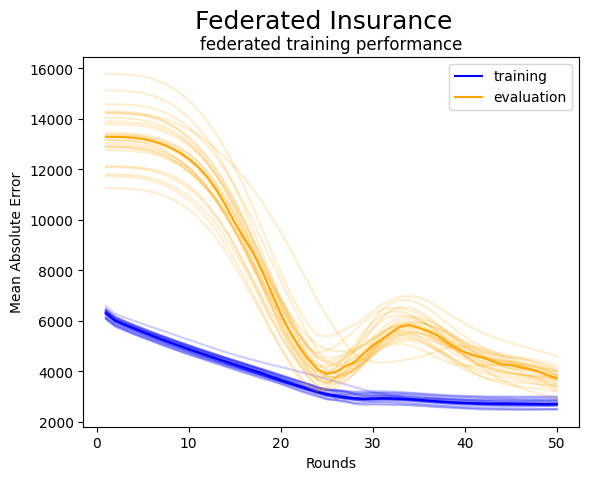

In [15]:
# plot train result (MAE)

y = np.array([[hist['mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()
yval = np.array([[hist['val_mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()


xran = range(1,y.shape[0] + 1)
plt.plot(xran, y, color = 'blue', alpha = .2)
plt.plot(xran, np.quantile(y,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(xran, yval, color = 'orange', alpha = .2)
plt.plot(xran, np.quantile(yval,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.xlabel("Rounds")
plt.ylabel("Mean Absolute Error")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('federated training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mae.png')
plt.show()

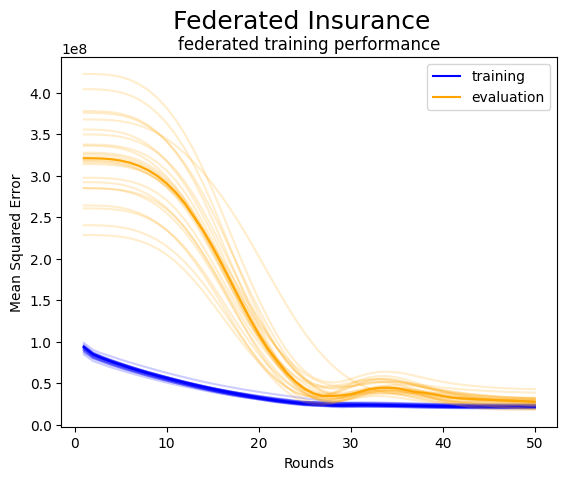

In [16]:
# plot train result (MSE)

y = np.array([[hist['mean_squared_error'] for hist in res['history']] for res in results_fed]).transpose()
yval = np.array([[hist['val_mean_squared_error'] for hist in res['history']] for res in results_fed]).transpose()


xran = range(1,y.shape[0] + 1)
plt.plot(xran, y, color = 'blue', alpha = .2)
plt.plot(xran, np.quantile(y,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(xran, yval, color = 'orange', alpha = .2)
plt.plot(xran, np.quantile(yval,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.xlabel("Rounds")
plt.ylabel("Mean Squared Error")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('federated training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mse.png')
plt.show()

### FED Test

In [17]:
# compute test 
results_fed_test = []

model = keras_blueprint(compile = True)


for i in tqdm.tqdm(range(len(results_fed))):

    # fetch test data
    clients_test = []
    for client_ind in range(len(clients)):
        indices_test = client_splits[client_ind][eval_ind][1]
        clients_test.append(clients[client_ind].iloc[indices_test])

    test_data = pd.concat(clients_test)
    X_test = test_data[features[:5]]
    y_test = test_data[target]

    # calculate test performance
    model_weights = results_fed[i]['process'].get_model_weights(results_fed[i]['state'])
    model_weights.assign_weights_to(model)
    
    perf_test = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))

    results_fed_test.append(perf_test)

100%|██████████| 25/25 [06:48<00:00, 16.32s/it]  


In [18]:
# show test results
table2 = pd.DataFrame(results_fed_test)
table2 = table2.set_axis(['test_'+ col for col in table2.columns], axis = 1)

table2.describe()[1:].to_csv(experiment_path + "results/performance_test_overview.csv", sep = ";")
table_all = pd.concat([table, table2], axis = 1)
table_all.describe()[1:].to_csv(experiment_path + "results/performance_overview.csv", sep = ";")
table_all.to_csv(experiment_path + "results/performance.csv", sep = ";")

table_all.describe()[1:].transpose().round(4)

,mean,std,min,25%,50%,75%,max
mean_absolute_error,2.736034e+03,1.368477e+02,2.491674e+03,2.672458e+03,2.713437e+03,2.833991e+03,3.000851e+03
mean_squared_error,2.163789e+07,1.377793e+06,1.951690e+07,2.066941e+07,2.131848e+07,2.250815e+07,2.432508e+07
loss,2.162266e+07,1.353995e+06,1.955227e+07,2.055526e+07,2.136639e+07,2.252563e+07,2.420188e+07
num_examples,4.812000e+04,4.082480e+01,4.810000e+04,4.810000e+04,4.810000e+04,4.810000e+04,4.820000e+04
num_batches,3.782000e+02,4.082000e-01,3.780000e+02,3.780000e+02,3.780000e+02,3.780000e+02,3.790000e+02
val_mean_absolute_error,3.727942e+03,3.603940e+02,2.947725e+03,3.482348e+03,3.740323e+03,4.000978e+03,4.596197e+03
val_mean_squared_error,2.764706e+07,5.706022e+06,1.771940e+07,2.479148e+07,2.738401e+07,3.048353e+07,4.288566e+07
val_loss,2.781249e+07,5.701792e+06,1.755234e+07,2.493460e+07,2.758152e+07,3.065595e+07,4.313458e+07
val_num_examples,1.080000e+02,0.000000e+00,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02
val_num_batches,4.000000e+00,0.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00


## Centralized DNN
---

Setup

Using 9 Features.

In [19]:
experiment_name = '02_central_new'

experiment_path = log_path + "/" + experiment_name + "/"
if not os.path.exists(experiment_path + 'logs'): os.makedirs(experiment_path + 'logs')
if not os.path.exists(experiment_path + 'models'): os.makedirs(experiment_path + 'models')
if not os.path.exists(experiment_path + 'results'): os.makedirs(experiment_path + 'results')

### CTR Train
---

In [20]:
%%time
# compute train

results_ctr = []

for i in range(n_evals):

    train_indices = [split[1][0] for split in client_splits]
    #test_indices = [split[1][1] for split in client_splits]

    rep  = int(i / nfolds)
    fold = int(i % nfolds)
    id = "r" + str(rep) + "f" + str(fold)
    print('======= rep %s - fold %s  =======' % (rep, fold))

    data_train = pd.concat([clients[i].iloc[train_indices[i]] for i in range(len(clients))])
    X_train = data_train[features[:9]] # include regions
    y_train = data_train[target]

    model = keras_blueprint(nfeatures = 9, compile = True)
    
    hist = train_model(
        model, X_train, y_train,
        epochs = n_epochs, 
        output_msr = "r2_score",
        callbacks = [CSVLogger(experiment_path + "logs/" + id + '_log.csv'  , separator =";")],
        seed = 42
    )
    model.save_weights(experiment_path + "models/" + id + '_weights.h5')

    results_ctr.append(hist)


======= rep 0 - fold 0  =======
R^2  = 0.8608,  time = 41.7 sec
======= rep 0 - fold 1  =======
R^2  = 0.8656,  time = 40.7 sec
======= rep 0 - fold 2  =======
R^2  = 0.8657,  time = 40.3 sec
======= rep 0 - fold 3  =======
R^2  = 0.8755,  time = 40.3 sec
======= rep 0 - fold 4  =======
R^2  = 0.8668,  time = 39.9 sec
======= rep 1 - fold 0  =======
R^2  = 0.8667,  time = 40.3 sec
======= rep 1 - fold 1  =======
R^2  = 0.8662,  time = 40.1 sec
======= rep 1 - fold 2  =======
R^2  = 0.8660,  time = 40.2 sec
======= rep 1 - fold 3  =======
R^2  = 0.8658,  time = 39.7 sec
======= rep 1 - fold 4  =======
R^2  = 0.8658,  time = 41.1 sec
======= rep 2 - fold 0  =======
R^2  = 0.8658,  time = 41.9 sec
======= rep 2 - fold 1  =======
R^2  = 0.8657,  time = 40.8 sec
======= rep 2 - fold 2  =======
R^2  = 0.8658,  time = 40.4 sec
======= rep 2 - fold 3  =======
R^2  = 0.8658,  time = 40.7 sec
======= rep 2 - fold 4  =======
R^2  = 0.8658,  time = 40.1 sec
======= rep 3 - fold 0  =======
R^2  = 0

In [21]:
# show train results
table = pd.DataFrame(
    [{key: val[-1] for key, val in hist.history.items()} for hist in results_ctr]
    ).assign(
    r2_score    = lambda x: x.r2_score * 100,
    val_r2_score = lambda x: x.val_r2_score * 100
)

table.describe()[1:].to_csv(experiment_path + "results/performance_train_overview.csv", sep = ";")
table.round(2)

,loss,mae,mean_squared_error,r2_score,val_loss,val_mae,val_mean_squared_error,val_r2_score
0,21518194.0,2617.40,21518194.0,86.08,23580600.0,2203.59,23580600.0,77.89
1,20788008.0,2544.83,20788008.0,86.56,24616640.0,2351.76,24616640.0,77.22
2,20779042.0,2538.73,20779042.0,86.57,24626090.0,2341.44,24626090.0,77.21
3,19229838.0,2343.28,19229838.0,87.55,23834786.0,2252.36,23834786.0,77.50
4,20617520.0,2505.23,20617520.0,86.68,24702490.0,2391.50,24702490.0,77.15
5,20640644.0,2509.52,20640644.0,86.67,24612160.0,2363.01,24612160.0,77.24
6,20703630.0,2523.49,20703630.0,86.62,24922390.0,2403.22,24922390.0,76.96
7,20741060.0,2528.43,20741060.0,86.60,24708876.0,2382.23,24708876.0,77.10
8,20759036.0,2534.41,20759036.0,86.58,24699148.0,2388.87,24699148.0,77.10
9,20766246.0,2533.79,20766246.0,86.58,24692314.0,2383.36,24692314.0,77.11


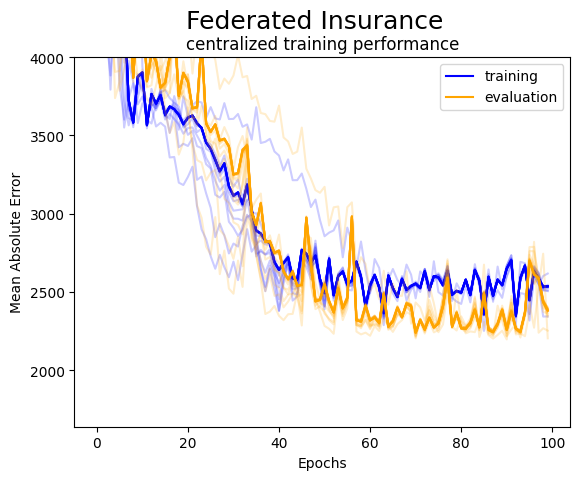

In [22]:
# plot train result (MAE)
y1 = np.array([hist.history["mae"] for hist in results_ctr]).transpose()
y2 = np.array([hist.history["val_mae"] for hist in results_ctr]).transpose()

plt.plot(y1, color = 'blue', alpha = .2)
plt.plot(np.quantile(y1,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(y2, color = 'orange', alpha = .2)
plt.plot(np.quantile(y2,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.ylim([None, 4000])

plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.suptitle('Federated Insurance', fontsize = 18)
plt.title('centralized training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mae.png')
plt.show()


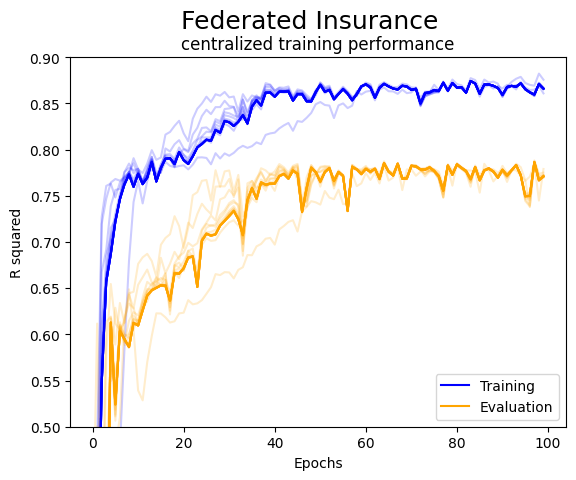

In [23]:
# plot train result (RSQ)
y1 = np.array([hist.history["r2_score"] for hist in results_ctr]).transpose()
y2 = np.array([hist.history["val_r2_score"] for hist in results_ctr]).transpose()

plt.plot(y1, color = 'blue', alpha = .2)
plt.plot(np.quantile(y1,.5, axis = 1), label = 'Training', color = 'blue')
plt.plot(y2, color = 'orange', alpha = .2)
plt.plot(np.quantile(y2,.5, axis = 1), label = 'Evaluation', color = 'orange')
plt.ylim([0.5, 0.9])
plt.xlabel("Epochs")
plt.ylabel("R squared")
plt.suptitle('Federated Insurance', fontsize = 18)
plt.title('centralized training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_rsq.png')
plt.show()



### CTR Test
---

In [24]:
# compute test
results_test_ctr = []

for i in tqdm.tqdm(range(
    3
    )):
    #train_indices = [split[1][0] for split in client_splits]
    test_indices = [split[1][1] for split in client_splits]

    data_test = pd.concat([clients[i].iloc[test_indices[i]] for i in range(len(clients))])
    X_test = data_test[features[:9]]
    y_test = data_test[target]

    model = results_ctr[i].model
    perf_test  = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))
    results_test_ctr.append(perf_test)

100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


In [25]:
# show test results
table2 = pd.DataFrame(results_test_ctr)
table2 = table2.set_axis(['test_'+ col for col in table2.columns], axis = 1)


table2.describe()[1:].to_csv(experiment_path + "results/performance_test_overview.csv", sep = ";")

table_all = pd.concat([table, table2], axis = 1)
table_all.describe()[1:].to_csv(experiment_path + "results/performance_overview.csv", sep = ";")
table_all.to_csv(experiment_path + "results/performance.csv", sep = ";")
table_all.describe()[1:].transpose().round(2)

,mean,std,min,25%,50%,75%,max
loss,2.071714e+07,348198.6626,1.922984e+07,2.075626e+07,2.075816e+07,2.076227e+07,2.151819e+07
mae,2.528662e+03,43.0132,2.343277e+03,2.532997e+03,2.535793e+03,2.536359e+03,2.617399e+03
mean_squared_error,2.071714e+07,348198.6626,1.922984e+07,2.075626e+07,2.075816e+07,2.076227e+07,2.151819e+07
r2_score,8.660870e+01,0.2236,8.607710e+01,8.657940e+01,8.658310e+01,8.658380e+01,8.755290e+01
val_loss,2.464437e+07,291758.8575,2.358060e+07,2.469231e+07,2.471973e+07,2.472672e+07,2.492239e+07
val_mae,2.368802e+03,44.9733,2.203588e+03,2.376977e+03,2.382227e+03,2.389200e+03,2.403218e+03
val_mean_squared_error,2.464437e+07,291758.8575,2.358060e+07,2.469231e+07,2.471973e+07,2.472672e+07,2.492239e+07
val_r2_score,7.714800e+01,0.1843,7.696460e+01,7.709120e+01,7.710220e+01,7.710840e+01,7.789330e+01
test_loss,3.246466e+07,253060.9524,3.217366e+07,3.238039e+07,3.258712e+07,3.261016e+07,3.263320e+07
test_mae,2.951895e+03,79.4579,2.900221e+03,2.906147e+03,2.912073e+03,2.977731e+03,3.043389e+03
